# Data Exploration - BOGO

The purpose of this notebook is to perform exploratory data analysis tasks to provide insights into the data that can further lead us towards understanding user/offer type match. This notebook is built using the cleaned data sets from the Data Wrangling notebooks.

In this analysis, I treat the other 2 offer types, bogo and discount, separately. At this point, we do not know whether or not users who are responsive to bogo offers are also responsive to discount offers, hence, we should analyze data for these two categories of offers separately. 

For each offer type, I compare Respond Yes group to Respond No group using these guidance questions and common assumptions:
1. Do users who respond yes to offers also spend more on the app in general?
2. How is income related to response? 
3. How is age related to response?
4. How is number of transactions related to response? (Assumption: user who is already more active on the app would be more likely to respond yes to offer)
5. Do users who respond yes also have more reward points? (Assumption: users who are engaged and motivated to earn more points would be more likely to respond yes to offers)
6. How does a user's membership length affect their response?
7. Does a user's gender affect response?
8. Does a user's average spending amount per transaction affect their response?

Note: Although "informational" offer type is included in the dataset, we should remove it from the data analysis. "Informational" offers have difficulty value of 0, which means that they do not cost Starbucks anything to send out, so we assume that Starbucks should send informational offers to _all_ of its reward users to inform them of new products. 

## Import libraries and data sets

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# read in the csv files
offer_response = pd.read_csv('data/offer_response.csv')
user = pd.read_csv('data/profile_cleaned.csv')

In [63]:
# Merge user an offer_response
df = pd.merge(offer_response, 
             user, 
             how='left', 
             on=['person'])

In [64]:
# TODO: explore NaNs

In [65]:
df = df.dropna().replace({True:1,False:0})

## BOGO - Data Exploration

In [66]:
df = df[df.offer_type == 'bogo']

In [67]:
yes_df = df[df.completed_offer == True]
no_df = df[df.completed_offer == False]

In [92]:
print(yes_df.shape[0], yes_df.shape[0]/df.shape[0])
print(no_df.shape[0], no_df.shape[0]/df.shape[0])

9044 0.6053142359949133
5897 0.39468576400508665


In [68]:
df.describe()

,completed_offer,age,income,membership_length,total_spending,response_rate,total_transactions,avg_spent_per_transaction,total_rewards
count,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000
mean,0.605314,55.052005,67525.332976,1161.338799,146.347012,0.590831,9.645004,17.288406,16.351315
std,0.488799,16.969140,21416.725910,417.575322,137.748989,0.240720,5.279720,16.212098,9.480823
min,0.000000,18.000000,30000.000000,587.000000,5.280000,0.166667,1.000000,1.311667,2.000000
25%,0.000000,44.000000,52000.000000,833.000000,60.780000,0.400000,6.000000,8.743750,9.000000
50%,1.000000,56.000000,66000.000000,1061.000000,118.420000,0.600000,9.000000,16.260000,15.000000
75%,1.000000,67.000000,83000.000000,1438.000000,187.520000,0.800000,13.000000,22.408571,23.000000
max,1.000000,101.000000,120000.000000,2410.000000,1608.690000,1.000000,36.000000,301.310000,55.000000


In [69]:
df.columns

Index(['person', 'completed_offer', 'offer_type', 'gender', 'age', 'income',
       'membership_length', 'total_spending', 'response_rate',
       'total_transactions', 'avg_spent_per_transaction', 'total_rewards'],
      dtype='object')

In [70]:
# Check out the correlation between the continuous variables
corr = df[['offer_type', 'gender', 'age', 'income',
       'membership_length', 'total_spending', 'response_rate',
       'total_transactions', 'avg_spent_per_transaction', 'total_rewards']].corr()

In [71]:
corr

,age,income,membership_length,total_spending,response_rate,total_transactions,avg_spent_per_transaction,total_rewards
age,1.000000,0.310726,-0.024924,0.081213,0.094164,-0.221760,0.189167,0.091680
income,0.310726,1.000000,-0.033555,0.285283,0.173994,-0.377882,0.472868,0.211764
membership_length,-0.024924,-0.033555,1.000000,0.081778,0.088333,0.378387,-0.055379,0.041768
total_spending,0.081213,0.285283,0.081778,1.000000,0.420319,0.249598,0.749106,0.427861
response_rate,0.094164,0.173994,0.088333,0.420319,1.000000,0.201439,0.223233,0.688644
total_transactions,-0.221760,-0.377882,0.378387,0.249598,0.201439,1.000000,-0.238343,0.149582
avg_spent_per_transaction,0.189167,0.472868,-0.055379,0.749106,0.223233,-0.238343,1.000000,0.246895
total_rewards,0.091680,0.211764,0.041768,0.427861,0.688644,0.149582,0.246895,1.000000


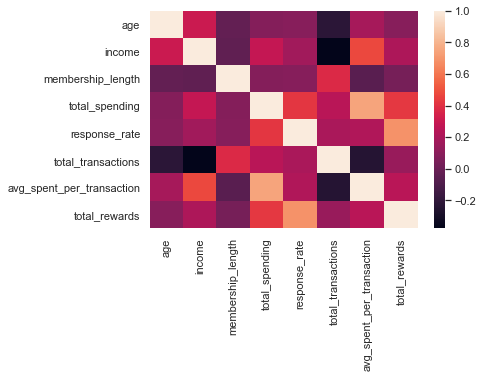

In [72]:
sns.heatmap(corr)

From the correlation analysis, we can see that **response rate** and **total rewards** have a high correlation score of 0.69. This correlation is interesting so we should investigate further below. Additionally, total spending and average amount spent per transaction also have a high correlation score (0.75) but that's more predictable because average spent is calculated from total spending.

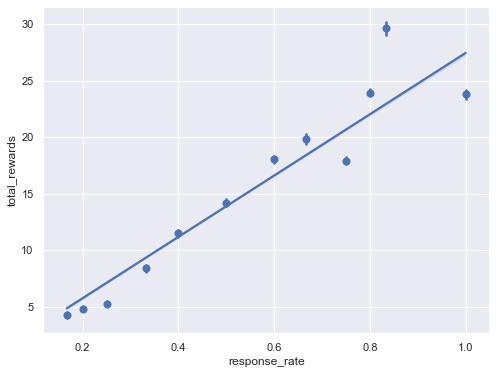

In [73]:
plt.figure(figsize= (8,6))
sns.set(color_codes=True)
sns.regplot(x=df.response_rate, y=df.total_rewards, x_estimator=np.mean)

#### Do users who respond yes to offers also spend more on the app in general?

([<matplotlib.axis.XTick at 0x1a2b4fe350>,
 <a list of 2 Text xticklabel objects>)

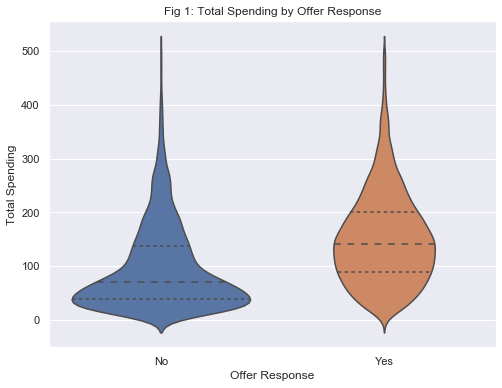

In [74]:
# Violin plot of total spending distribution
# excluding total spending over $500 as these are outliers and they distort the chart
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='total_spending', data = df[df.total_spending <= 500], inner='quartile')

plt.title('Fig 1: Total Spending by Offer Response')
plt.ylabel('Total Spending')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

From the plot above, we see that there's a big difference in total spending between users who respond Yes vs No to bogo offers. The graph for the No group is highly concentrated on the bottom, showing that most of the users who respond No to bogo offers spend $100 or less in total. The graph for the Yes group shows that Yes group users spend more than the No group, and the distribution of spending is less concentrated around one amount. 

In [75]:
statistic, pvalue = stats.ttest_ind(yes_df.total_spending, no_df.total_spending)
print(pvalue < 0.05) # Using 5% threshold

True


Calculating the T-test for the means of two groups at 5% threshold shows us that the differences in the average value of the total spending of two groups are significant, and we can reject the null hypothesis

#### How is income related to response?

([<matplotlib.axis.XTick at 0x1a2b4b4d50>,
 <a list of 2 Text xticklabel objects>)

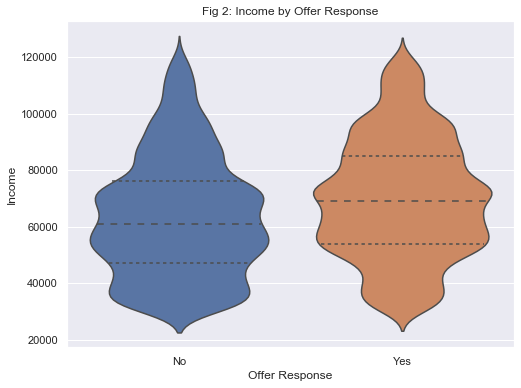

In [76]:
# Violin plot of income distribution
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='income', data = df, inner='quartile')

plt.title('Fig 2: Income by Offer Response')
plt.ylabel('Income')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

In [77]:
statistic, pvalue = stats.ttest_ind(yes_df.income, no_df.income)
print(pvalue < 0.05) # Using 5% threshold

True


#### How is age related to response?

([<matplotlib.axis.XTick at 0x1a2b4ba290>,
 <a list of 2 Text xticklabel objects>)

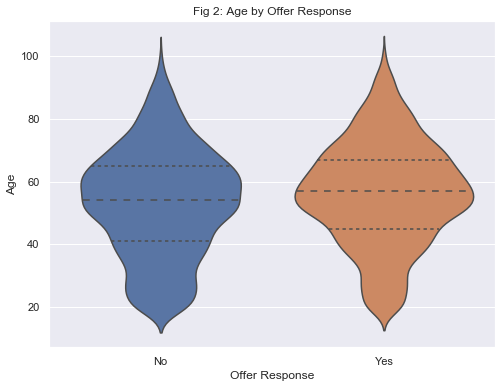

In [78]:
# Violin plot of income distribution
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='age', data = df, inner='quartile')

plt.title('Fig 2: Age by Offer Response')
plt.ylabel('Age')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

In [79]:
statistic, pvalue = stats.ttest_ind(yes_df.age, no_df.age)
print(pvalue < 0.05) # Using 5% threshold

True


#### How is number of transactions related to response?

([<matplotlib.axis.XTick at 0x1a2b4ad590>,
 <a list of 2 Text xticklabel objects>)

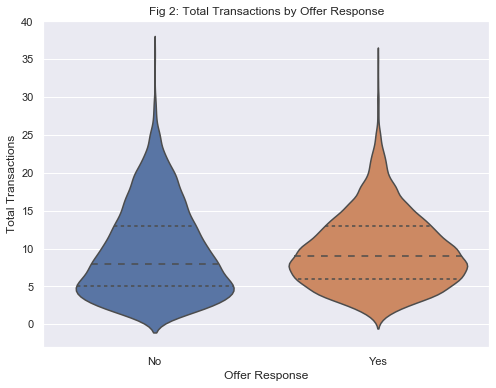

In [80]:
# Violin plot of income distribution
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='total_transactions', data = df, inner='quartile')

plt.title('Fig 2: Total Transactions by Offer Response')
plt.ylabel('Total Transactions')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

In [81]:
statistic, pvalue = stats.ttest_ind(yes_df.total_transactions, no_df.total_transactions)
print(pvalue, pvalue < 0.05) # Using 5% threshold

0.2902858992419705 False


The p-value is 0.29, suggesting that we cannot reject the null hypothesis which states that there's no significant difference between the average of total transactions between the Yes response group and the No response group 

#### Do users who respond yes also have more reward points?

([<matplotlib.axis.XTick at 0x1a2c02cc90>,
 <a list of 2 Text xticklabel objects>)

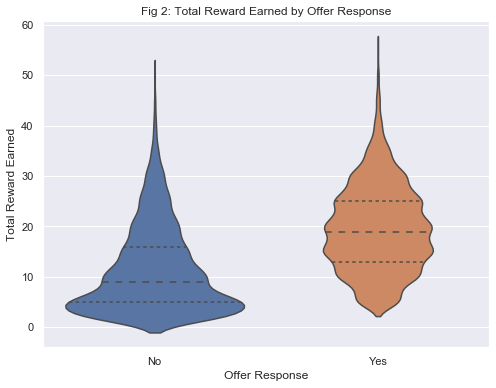

In [82]:
# Violin plot of income distribution
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='total_rewards', data = df, inner='quartile')

plt.title('Fig 2: Total Reward Earned by Offer Response')
plt.ylabel('Total Reward Earned')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

In [83]:
statistic, pvalue = stats.ttest_ind(yes_df.total_rewards, no_df.total_rewards)
print(pvalue, pvalue < 0.05) # Using 5% threshold

0.0 True


#### How does a user's membership length affect their response?

([<matplotlib.axis.XTick at 0x1a28312690>,
 <a list of 2 Text xticklabel objects>)

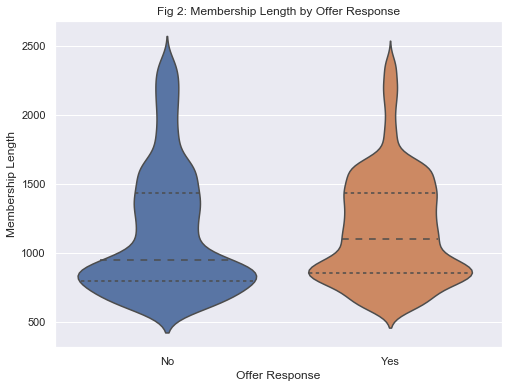

In [84]:
# Violin plot of income distribution
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='membership_length', data = df, inner='quartile')

plt.title('Fig 2: Membership Length by Offer Response')
plt.ylabel('Membership Length')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

In [85]:
statistic, pvalue = stats.ttest_ind(yes_df.membership_length, no_df.membership_length)
print(pvalue < 0.05) # Using 5% threshold

True


#### Does a user's gender affect response?

In [86]:
yes_df.gender.value_counts()/yes_df.shape[0]*100

M    49.458204
F    48.816895
O     1.724900
Name: gender, dtype: float64

In [87]:
no_df.gender.value_counts()/no_df.shape[0]*100

M    60.641004
F    38.002374
O     1.356622
Name: gender, dtype: float64

([<matplotlib.axis.XTick at 0x1a28377f90>,
 <a list of 2 Text xticklabel objects>)

<Figure size 720x576 with 0 Axes>

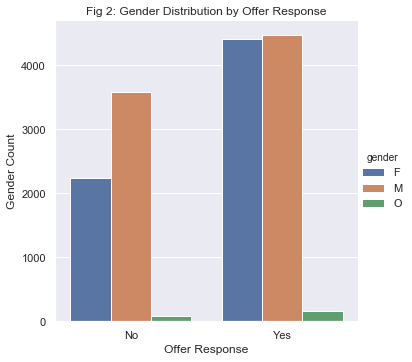

In [88]:
plt.figure(figsize=(10,8))
sns.catplot(x="completed_offer", kind="count", hue="gender", data=df);
plt.title('Fig 2: Gender Distribution by Offer Response')
plt.ylabel('Gender Count')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

For the group that responds yes to bogo offer, there is an even distribution between male and female users. But there is a much larger representation of men in the user group that responds No to bogo offers. In both response group, users with Other gender represent around 1.5% of users.

#### Does a user's average spending amount per transaction affect their response?

([<matplotlib.axis.XTick at 0x1a2ba75310>,
 <a list of 2 Text xticklabel objects>)

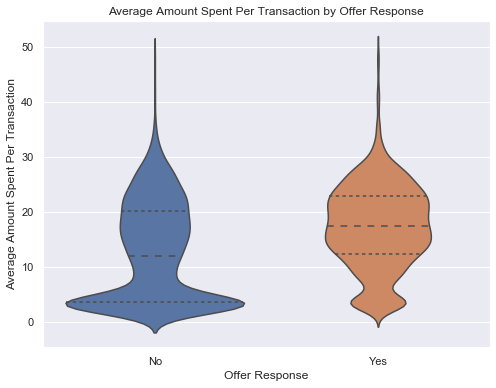

In [89]:
# Violin plot of income distribution
plt.figure(figsize= (8,6))
sns.violinplot(x='completed_offer', y='avg_spent_per_transaction', data = df[df.avg_spent_per_transaction < 50], inner='quartile')

plt.title('Average Amount Spent Per Transaction by Offer Response')
plt.ylabel('Average Amount Spent Per Transaction')
plt.xlabel('Offer Response')
plt.xticks([0,1], ['No','Yes'])

In [90]:
statistic, pvalue = stats.ttest_ind(yes_df.avg_spent_per_transaction, no_df.avg_spent_per_transaction)
print(pvalue < 0.05) # Using 5% threshold

True


There is a lot more variance in average amount spent per transaction within the No response group compared to the Yes response group. Majority of users in the No response group spend on average of less than \$5 per transaction, while the majority of the Yes group spend on average between \$15 to \$20